In [25]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [26]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Generate some SM samples

In [27]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [28]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

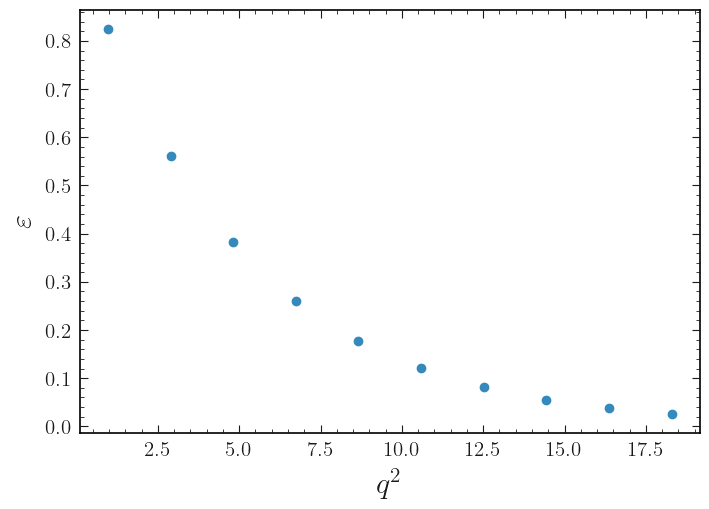

In [29]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

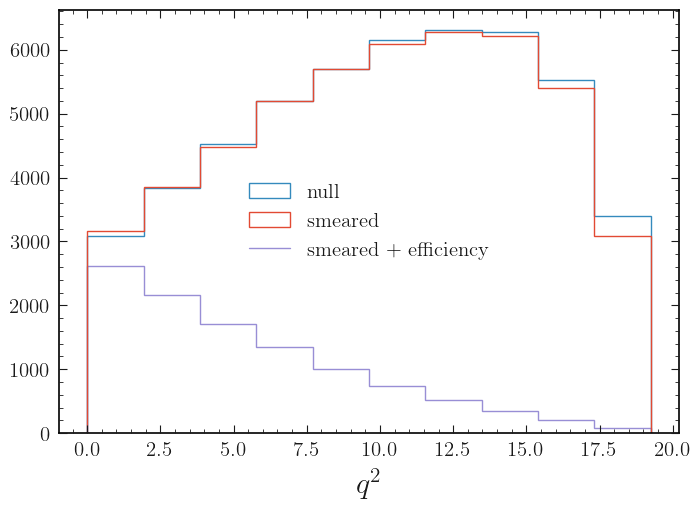

In [30]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [31]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cVR}'].set(0.0)
p['sbnunu::Re{cSL}'].set(0.5)
p['sbnunu::Re{cSR}'].set(0.0)
p['sbnunu::Re{cTL}'].set(0.5)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [32]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

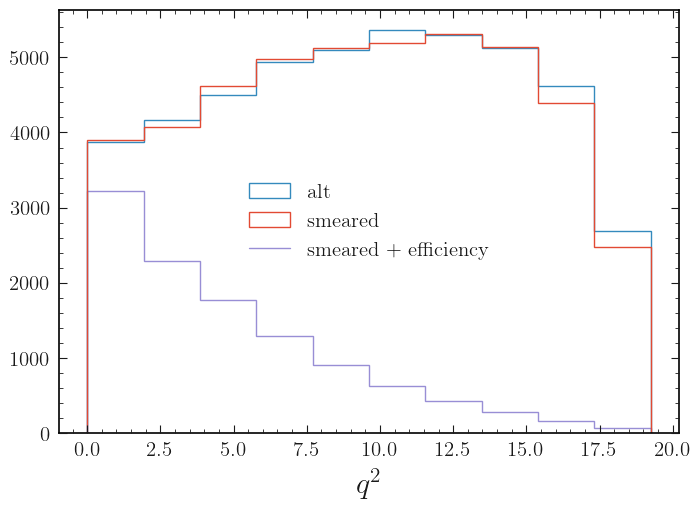

In [33]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [34]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [35]:
null = null_pred()
alt = alt_pred()

In [36]:
ana  = analysis()
cvl  = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
cvr  = ana.parameters['sbnunu::Re{cVR}'         ].evaluate()
csl  = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
csr  = ana.parameters['sbnunu::Re{cSR}'         ].evaluate()
ctl  = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()

In [37]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.001249,-0.015391,-0.149272,-0.000392,0.010801,0.102102,-0.001557,-0.009200
1,-0.015391,0.256465,1.956415,0.008476,-0.169091,-1.787828,0.162358,1.113478
2,-0.149272,1.956415,21.305733,0.045327,-1.355687,-12.006146,-0.587667,-4.252910
3,-0.000392,0.008476,0.045327,0.000561,-0.007770,-0.093994,0.015366,0.106638
4,0.010801,-0.169091,-1.355687,-0.007770,0.159369,1.644268,-0.139398,-0.956239
5,0.102102,-1.787828,-12.006146,-0.093994,1.644268,18.320518,-2.307115,-15.897721
6,-0.001557,0.162358,-0.587667,0.015366,-0.139398,-2.307115,0.872447,6.081553
7,-0.009200,1.113478,-4.252910,0.106638,-0.956239,-15.897721,6.081553,42.588645


In [38]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (v0, v1, v2, a10, a11, a12, a121, a122), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()])

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

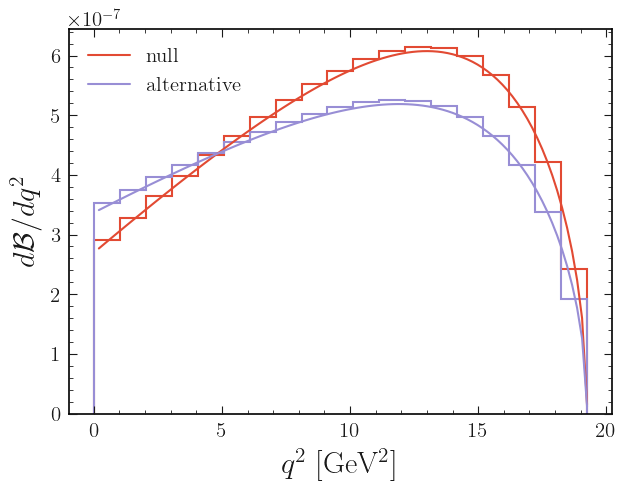

In [49]:
cvl = 5.
cvr = 0.
csl = 0.5
csr = 0.
ctl = 0.5

pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a10, a11, a12, a121, a122)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

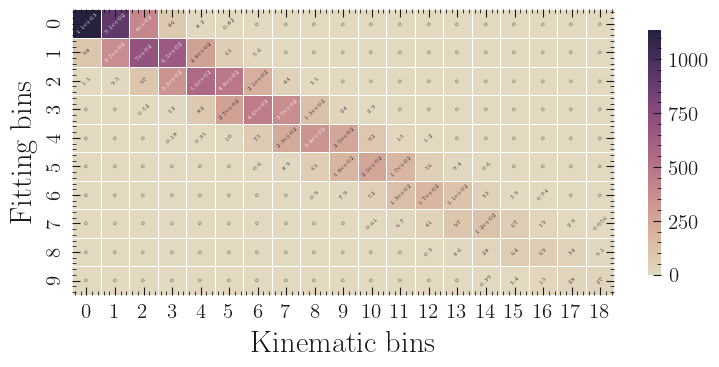

In [40]:
plot.map(cmod)

## Set up the model

In [41]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [2613.2652000690155,
      2160.4431750856643,
      1711.077084881691,
      1349.0846923651184,
      1007.6443057298692,
      732.4613891866223,
      514.1247864137647,
      346.2150417511666,
      204.64643720539445,
      79.71249667203512],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [51.12010563436871,
        46.4805677147522,
        41.365167531169156,
        36.72988827052321,
        31.74341358029834,
        27.06402389125871,
        22.674319976876145,
        18.606854697964582,
        14.305468786635217,
        8.92818551957984]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}}]}]}]}

## Save and load model

In [42]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [43]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.111273
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.61459
W MnPosDef Added to diagonal of Error matrix a value 1.11459
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0269781 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -1.76397
W MnPosDef Added to diagonal of Error matrix a value 2.26397
W VariableMetricBuilder gdel = -26498.9
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0873215 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.165039
W MnPosDef Added to diagonal of Error matrix a value 0.66504
W VariableMetricBuilder gdel = -33.2273


{'cvl': array([4.81286187, 0.481054  ]),
 'cvr': array([0., 0.]),
 'csl': array([0.02880868, 2.74369564]),
 'csr': array([0., 0.]),
 'ctl': array([0.5422545 , 0.03921019]),
 'FF_decorrelated[0]': array([0.25191691, 0.90920162]),
 'FF_decorrelated[1]': array([-0.06573077,  0.91213837]),
 'FF_decorrelated[2]': array([-0.12275722,  0.93272196]),
 'FF_decorrelated[3]': array([-0.03772569,  0.99110963]),
 'FF_decorrelated[4]': array([0.06452515, 0.98200155]),
 'FF_decorrelated[5]': array([-0.02662496,  0.99274342]),
 'FF_decorrelated[6]': array([0.02408935, 0.99232761]),
 'FF_decorrelated[7]': array([-0.01404412,  0.99263736]),
 'mu': array([1., 0.]),
 'stat': [[1.0118129373083322, 0.017538878354904808],
  [0.9768617740649302, 0.01701387002299759],
  [1.007731248183633, 0.018728340099584684],
  [1.0042078417267877, 0.02124529992516161],
  [0.9975508229440504, 0.02474332062423351],
  [0.993162614546271, 0.02924066383985352],
  [1.0040850065675746, 0.034936860968467986],
  [1.0069607372299874

In [44]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.8128618677059505,
 'cvr': 0.0,
 'csl': 0.028808683721283847,
 'csr': 0.0,
 'ctl': 0.5422545025233232,
 'FF[0]': 0.362915299002394,
 'FF[1]': -1.0446732588282692,
 'FF[2]': 2.502555079306538,
 'FF[3]': 0.29243257215075896,
 'FF[4]': 0.4253002267474835,
 'FF[5]': 0.663591252370211,
 'FF[6]': 0.7513108726888913,
 'FF[7]': 2.2804320458480043,
 'mu': 1.0,
 'stat': [1.0118129373083322,
  0.9768617740649302,
  1.007731248183633,
  1.0042078417267877,
  0.9975508229440504,
  0.993162614546271,
  1.0040850065675746,
  1.0069607372299874,
  1.0101782293691042,
  0.9963508498820022]}

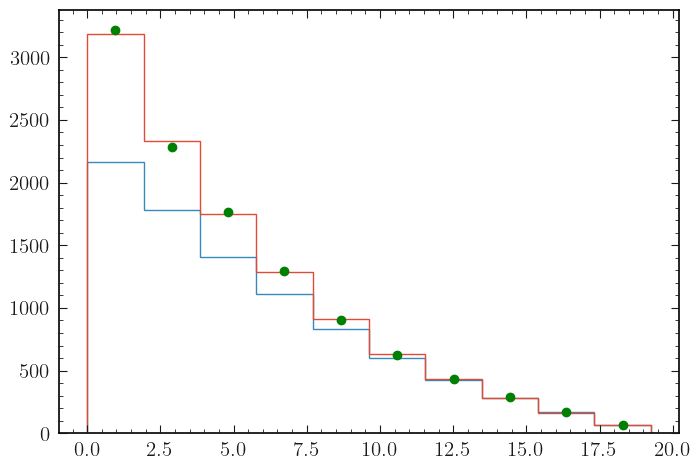

In [45]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')